# Super Human Humor with GPT2

## Load dataset

All r/jokes reddit submissions till 02/2017 from https://github.com/taivop/joke-dataset.

I scraped all submissions with more than 5 upvotes from 02/2017 to 03/2020 with https://pushshift.io/.

In [1]:
import pandas as pd

In [2]:
jokes2017 = pd.read_json("drive/MyDrive/Colab Notebooks/reddit_jokes_before_2017.json")
jokes2020 = pd.read_json("drive/MyDrive/Colab Notebooks/reddit_jokes_2017_2020.json")
jokes2020 = jokes2020.drop("created", axis=1)

In [3]:
joke_data = jokes2017.append(jokes2020)
joke_data.shape

(386253, 4)

In [4]:
joke_data = joke_data[~joke_data.body.isin(["[Removed]", "[Deleted]", "[removed]", "[deleted]"])]
joke_data.shape

(377704, 4)

In [5]:
joke_data["joke"] = joke_data["title"] + "\n" + joke_data["body"]
joke_data["length"] = joke_data[["joke"]].applymap(lambda x: len(x))
joke_data = joke_data[["joke","length", "score"]]

#### Filter jokes for popularity and length

In [6]:
best_jokes = joke_data[
                       (joke_data.score >= 100) &
                       (joke_data.length <= 300)
                       ]
best_jokes = best_jokes.sort_values("score", ascending=False)
print(best_jokes.shape)
best_jokes.head()

(32690, 3)


,joke,length,score
139246,Calm down about the Net Neutrality thing...\nP...,142,122825
34603,If your surprised that Jeffrey Epstein commite...,109,95511
162930,V\nV\n\n*Edit: seems like the ctrl key on my k...,67,95020
126024,The only two white actors in Black Panther are...,269,87338
135641,Ajit Pai.\nThat's it. That's the whole fucking...,226,85664


In [7]:
jokes = best_jokes.joke

In [8]:
jokes.head()

139246    Calm down about the Net Neutrality thing...\nP...
34603     If your surprised that Jeffrey Epstein commite...
162930    V\nV\n\n*Edit: seems like the ctrl key on my k...
126024    The only two white actors in Black Panther are...
135641    Ajit Pai.\nThat's it. That's the whole fucking...
Name: joke, dtype: object

In [9]:
jokes.shape

(32690,)

#### The following code is adapted from this [blog post](https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93).

## Load GPT2 Tokenizer from huggingface's transformers

In [10]:
%%capture
!pip install transformers

In [11]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


[36674, 8255]

#### Limit the maximum token length because of RAM limitations.

In [12]:
joke_tokens = pd.DataFrame(jokes.copy())
joke_tokens["len_tokens"] = joke_tokens.applymap(lambda x: len(tokenizer.encode(x)))
joke_tokens = joke_tokens.sort_values("len_tokens", ascending=False)
joke_tokens

,joke,len_tokens
6949,‌‌After s‌‌ex w‌‌ith m‌‌y n‌‌ew g‌‌irlfriend l...,188
6023,The p‌‌olice c‌‌alled t‌‌o t‌‌ell m‌‌e t‌‌hat ...,180
6338,I was fucking my secretary up her arse and my ...,175
37729,How many wipes does it take to clean a keyboar...,159
100758,A List of Forts.\nA Fort.\n\nB Fort.\n\nC Fort...,143
...,...,...
103973,Donald Trump\n,3
115133,Pao\n,3
185526,Congress\n,2
115174,Reddit\n,2


In [13]:
jokes = joke_tokens.joke[joke_tokens.len_tokens <= 100]
jokes.shape

(32663,)

In [14]:
max_flavour = max([len(tokenizer.encode(joke)) for joke in jokes])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 100 tokens long.


## Create PyTorch Data Loaders

In [18]:
# reproducibility
def seed_everything(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [16]:
bs = 32 # batchsize

In [17]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class JokeDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):
        self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the 
            pad token. 
            """

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                     truncation=True, 
                                     max_length=max_length, 
                                     padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not. 
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [19]:
from torch.utils.data import random_split

dataset = JokeDataset(jokes, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 29396 samples for training, and 3267 samples for validation testing'

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = bs 
        )

## Load pretrained GPT2 from huggingface

In [21]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

## Fine-tune GPT2

In [15]:
!nvidia-smi

Wed Mar 31 13:58:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# This step is optional but will enable reproducible runs.
seed_val = 42
seed_everything(seed_val)

In [23]:
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [24]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [25]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [26]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 919. Loss:0.9757152795791626. Time:0:01:33
Example output:  bipartisanTwo Men in Gold, The Two Heaves That Make the best of the worst.
He was the only man in our history who could make our dreams come true.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 919. Loss:1.072882056236267. Time:0:03:08
Example output:  increasingMy husband: "You see it? You see me now." 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 919. Loss:0.9767699837684631. Time:0:04:43
Example output: dayMy wife says to me, "Just write this book"
I say, "Do you want a man or a woman?"

She says, "Yes and don't be surprised because your wife will do your job."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 919. Loss:0.9983767867088318. Time:0:06:18
Example output:  HangWhy did the man from Iceland go to hell?
Because he could never put food on the table.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 919. Loss:0.9815222024917603. Time:0:07:52
Example output:  foodsWhat do you call a racist guy?
A black guy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 919. Loss:0.8409900069236755. Time:0:09:25
Example output:  trailThe last man left me.
Because he lost everything


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 919. Loss:0.940541684627533. Time:0:10:57
Example output: intendI'm a vegan and I love all the meat, meat, chicken, and eggs, but there are too many trans fats.
Because you'll never find your legs on a tree.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 919. Loss:0.700189471244812. Time:0:12:29
Example output:  surroundDid you hear about the man who was obsessed with becoming a star at the gym?
He started his career at the gym.. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 919. Loss:0.8360730409622192. Time:0:14:01
Example output:  reflexI love my girls like I love my pizza
But I have my own servers
Average Training Loss: 1.2551103594253838. Epoch time: 0:14:18
Validation loss: 0.8398853013816389. Validation Time: 0:00:32
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 919. Loss:0.8163537979125977. Time:0:01:32
Example output:  displayWhat is the difference between an Englishman and an Irishman?
The Englishman only gets a penny


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 919. Loss:0.6686833500862122. Time:0:03:04
Example output:  pastorWhat does a pedophile's least favorite letter have in common with his best friend?
It reads, “We’re not talking.”


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 919. Loss:0.6848289370536804. Time:0:04:37
Example output:  illicitWhat's the difference between a well dressed man on a bike and a well dressed man on a bicycle?
Attire.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 919. Loss:0.9569305181503296. Time:0:06:10
Example output:  LiberationWhat did the blonde say to the eye doctor on the Intensive Care Unit?
"How do I see myself in five years, now?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 919. Loss:0.7483964562416077. Time:0:07:43
Example output:  NamWhat do you call a blonde that runs on her tail?
A blonde toupee.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 919. Loss:0.7118595838546753. Time:0:09:15
Example output: IONI was just diagnosed with stage 4 agnobility....
It's a stage 2 stage.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 919. Loss:0.5912878513336182. Time:0:10:47
Example output:  glimpseMy lesbian neighbors think I'm a stud...
because I have a boner... 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 919. Loss:0.7121047973632812. Time:0:12:19
Example output:  LaureI love my coffee
so I have a place where I canresso it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 919. Loss:0.9084447026252747. Time:0:13:52
Example output: ismHow does a man get the police to report a murder on him?
The police have been called.
Average Training Loss: 0.7752991439338867. Epoch time: 0:14:09
Validation loss: 0.7792768281640359. Validation Time: 0:00:32
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 919. Loss:0.6436154246330261. Time:0:01:32
Example output: ounTwo guys were talking about the effects of smoking weed on your body...
They said smoking weed causes "burns" 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 919. Loss:0.583911657333374. Time:0:03:05
Example output:  electionHow do you make a hippie joke
A man walks into a bar and says, "I'll have a beer."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 919. Loss:0.7605085372924805. Time:0:04:37
Example output:  crazyWhat do you call a fat psychic?
A four chin teller.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 919. Loss:0.7425921559333801. Time:0:06:09
Example output:  benchI lost a few coins today and I forgot to carry a newspaper...
... so I stole that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 919. Loss:0.60273277759552. Time:0:07:42
Example output:  incorporatedSo many Brits don't realise how many times they've been to Chernobyl.
It’s always a great thing to hear one British mum tell her daughter. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 919. Loss:0.631446123123169. Time:0:09:14
Example output: PeterA man who is in a hurry wakes up and his grandmother tells him, "Your nose is starting to show up."


"No, no," replied the man.  "My gums are all getting bigger."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 919. Loss:0.6942398548126221. Time:0:10:47
Example output: uringWhy are all jewish men circumcised?
So they can shave their privates.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 919. Loss:0.5334432721138. Time:0:12:19
Example output:  reproductiveA bear goes to the barber's shop
"I'll have a haircut on the nose!"

He nods and says "I'll have to wash my hands first."

The barber nods, "I don't want to be late."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 919. Loss:0.5597162246704102. Time:0:13:51
Example output:  zoneMy father taught me one day that a good way to motivate your kids is to always say “I’m already doing this” and then you’re doing it again...
Maybe teaching a dad can make you a better dad
Average Training Loss: 0.656819901476747. Epoch time: 0:14:09
Validation loss: 0.7576851671181836. Validation Time: 0:00:33
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 919. Loss:0.6144763827323914. Time:0:01:32
Example output:  commitsWhat do you get when you cross an insomniac with a dyslexic?
Someone who sits at the top of your head, but stands out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 919. Loss:0.4692046046257019. Time:0:03:05
Example output:  ironyI accidentally swallowed some Scrabble tiles...

As a former player of the Nintendo 64, I don't know why I keep getting stuck in that weirdo habit. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 919. Loss:0.512018620967865. Time:0:04:37
Example output:  SahWhat do you call a communist sniper?
A marxman. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 919. Loss:0.6045539379119873. Time:0:06:10
Example output:  BryanWhy do native Americans hate snow?
Because it's white and settles on their land.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 919. Loss:0.630866527557373. Time:0:07:42
Example output:  spiritsI just realized that being homeless is NOT a fun job!
I've been working out for the past 8 months and I've already started a couple of triathlons.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 919. Loss:0.5862810611724854. Time:0:09:14
Example output:  seesIf a Chinese guy refuses to be stoned by a Chinese girl, and is raped by a german girl, he will be asked to purchase some Viagra
He will be completely harmless until you ask him to pronounce it aloud 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 919. Loss:0.5213043689727783. Time:0:10:47
Example output:  hungryWhat do women and refrigerators have in common?
Both are killing your baby, and both are making your corpse look and smell like it was made of meat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 919. Loss:0.5127507448196411. Time:0:12:20
Example output:  PTI accidentally swallowed an ice cube
As I was rolling down my grave I realized I had the body of an 18 year old


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 919. Loss:0.5704272389411926. Time:0:13:52
Example output: üMy girlfriend dumped me for talking too much about video games
She still isn't talking to me
Average Training Loss: 0.5688626759070436. Epoch time: 0:14:09
Validation loss: 0.7618596264459554. Validation Time: 0:00:32
Total training took 0:58:55


## Investigate Losses

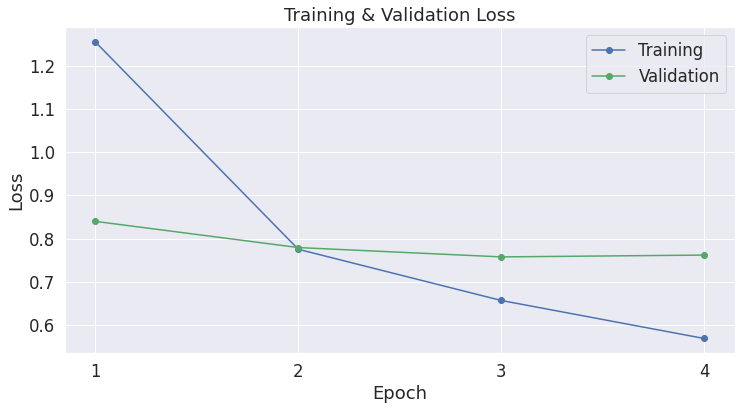

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Generate Jokes

In [28]:
model.eval()
seed_everything(42)

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=25 # if set then no sample?
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I told my psychiatrist about my feelings of suicidal tendencies...
He sent him a suicide note



1: Why do Sumo wrestlers shave their legs in between their sets?
Because Sumo wrestlers have a great ass. 


2: I like my women like I like my coffee
7 years old, mostly,

6 months old, with a little extra coffee,

9 months old, with nothing but a light load of mayonnaise on the coffee stick

What do you call a girl who doesn't have coffee? 


3: What’s the difference between a pick pocket and a peeping tom?
A pick pocket snatches watches.


4: My wife asked me which shampoo I should apply.
So I just gave her 3 different. Guess I should try Tide Pods or something...


5: I got fired from the calendar factory today because I kept mis-shoring dates.
I'm not putting in enough dates.


6: Did you know that the Chinese make white noise, like they do on TV?
You can't hear them on the street, they just make white noise.


7: I’m getting tired of people saying "I can’t understand you" and "You m

## Save Model

In [29]:
import os

output_dir = 'drive/MyDrive/Colab Notebooks/Jokster'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('drive/MyDrive/Colab Notebooks/Jokster/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/Jokster/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/Jokster/vocab.json',
 'drive/MyDrive/Colab Notebooks/Jokster/merges.txt',
 'drive/MyDrive/Colab Notebooks/Jokster/added_tokens.json')